In [1]:
from random import seed as random_seed
random_seed(10)
from numpy.random import seed as np_random_seed
np_random_seed(10)
from tensorflow import set_random_seed as tf_set_random_seed
tf_set_random_seed(10)

/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/miniconda3/envs/tf13/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import sys
import cv2
from tqdm import tqdm
import glob

from keras.layers.advanced_activations import LeakyReLU
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras import initializers
import random
from skimage.transform import resize, rotate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import precision_recall_fscore_support as score

# Commented out IPython magic to ensure Python compatibility.
#from __future__ import print_function, division
# %matplotlib inline



Using TensorFlow backend.


In [3]:
def load_data(path,labels):
    images=[]
    cnt=0
    for x in labels:
        c_path = path+x+'/'
        files = glob.glob(c_path+'*')
        files.sort()
        # Read all images
        for y in files:
            tmp = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
            #print(tmp.shape)
            tmp = cv2.resize(tmp,(256,256),Image.ANTIALIAS)

            images.append(tmp)
            
            cnt+=1
            if cnt%100==0:
                print(str(cnt)+' set finish!!')
    print('All of dataset are loaded!')    
    print('==========================================')
    
    #images = np.y(np.reshape(images,(len(images),256,256,1)))
    
    return np.array(images)

In [4]:
def list_to_arr(img_list):
    arr = []
    for x in img_list:

        arr.append(x[:,:,0])
        
    arr = np.asarray(np.reshape(arr,(len(img_list),x.shape[0],x.shape[1],1)))
    
    return arr

In [5]:
def unet(pretrained_weights = None, input_size=(256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'relu')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [6]:
def rotate_img(labeled,unlabeled,count,min_rads,max_rads):
    ratated_label = []
    rotated_unlabel = []
    icnt=1
    
    for j in range(count):
        random_rads = [random.uniform(min_rads, max_rads) for zz in range(len(labeled))]
        for i in range(len(labeled)):
            labeled_rot = rotate(labeled[i], random_rads[i])
            unlabeled_rot = rotate(unlabeled[i], random_rads[i])
            ratated_label.append(labeled_rot)
            rotated_unlabel.append(unlabeled_rot)
            
            if icnt%500==0:
                print(str(icnt)+' set rotated!')
            icnt+=1
        
    print('Done!==================================================')
    ratated_label = np.asarray(ratated_label)
    rotated_unlabel = np.asarray(rotated_unlabel)

    return ratated_label,rotated_unlabel

## Original Data (Just flip, not cropped)

In [7]:
label_list = ['class1','class2','class3']
#X_area = (0,0,1400,1400)
X  = load_data('/data/3rdDental/Unlabeled_Cropped_Data/PNG/',label_list)
y = load_data('/data/3rdDental/Labeled_Cropped_Data/PNG/',label_list)

100 set finish!!
200 set finish!!
300 set finish!!
400 set finish!!
All of dataset are loaded!
100 set finish!!
200 set finish!!
300 set finish!!
400 set finish!!
All of dataset are loaded!


In [8]:
X2  = load_data('/data/3rdDental/New_V2_Unlabeled_Cropped_Data/PNG/',label_list)
y2 = load_data('/data/3rdDental/New_V2_Labeled_Cropped_Data/PNG/',label_list)
X3  = load_data('/data/3rdDental/New_V3_Unlabeled_Cropped_Data/PNG/',label_list)
y3 = load_data('/data/3rdDental/New_V3_Labeled_Cropped_Data/PNG/',label_list)

All of dataset are loaded!
All of dataset are loaded!
100 set finish!!
200 set finish!!
All of dataset are loaded!
100 set finish!!
200 set finish!!
All of dataset are loaded!


In [9]:
X = np.concatenate((X,X2,X3))
y = np.concatenate((y,y2,y3))

In [10]:
X = (X.astype(np.float32))/X.max()
y = (y.astype(np.float32))/y.max()


In [11]:
X = np.expand_dims(X,-1)
y = np.expand_dims(y,-1)

In [12]:
X.shape

(690, 256, 256, 1)

In [13]:
y.shape

(690, 256, 256, 1)

In [14]:
model = unet()
model.load_weights('sav/unet_256/0300.hdf5')
model.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


/root/miniconda3/envs/tf13/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [15]:
inputs = model.predict(X)
inputs = inputs - X
outputs = y-X

In [16]:
threshold = 0.007
Xs = np.copy(inputs)
ys = np.copy(outputs)

Xs[Xs<threshold]=0
ys[ys<threshold]=0

    

In [35]:
np.save('V1to3_inpaint_data.npy',Xs)
np.save('V1to3_inpaint_label.npy',ys)


In [7]:
X = np.load('V1to3_inpaint_data.npy')
y = np.load('V1to3_inpaint_label.npy')


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=1,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.07,random_state=1,shuffle=True)

In [10]:
print('Training set : ',X_train.shape)
print('Validation set : ',X_val.shape)
print('Test set : ',X_test.shape)

Training set :  (609, 256, 256, 1)
Validation set :  (46, 256, 256, 1)
Test set :  (35, 256, 256, 1)


In [11]:

print('Dataset shape : ',X.shape)
print('Label shape : ',y.shape)
print('Dataset max : ',X.max())
print('Dataset min : ',X.min())
print('Label max : ',y.max())
print('Label min : ',y.min())

Dataset shape :  (690, 256, 256, 1)
Label shape :  (690, 256, 256, 1)
Dataset max :  1.0153862
Dataset min :  0.0
Label max :  0.98039216
Label min :  0.0


In [12]:
X_rot, y_rot = rotate_img(X_train,y_train,10,-20,20)

500 set rotated!
1000 set rotated!
1500 set rotated!
2000 set rotated!
2500 set rotated!
3000 set rotated!
3500 set rotated!
4000 set rotated!
4500 set rotated!
5000 set rotated!
5500 set rotated!
6000 set rotated!
Done!==================================================


In [13]:
X_train = np.concatenate((X_train,X_rot))
y_train = np.concatenate((y_train,y_rot))

In [14]:
print('Training set : ',X_train.shape)
print('Validation set : ',X_val.shape)
print('Test set : ',X_test.shape)

Training set :  (6699, 256, 256, 1)
Validation set :  (46, 256, 256, 1)
Test set :  (35, 256, 256, 1)


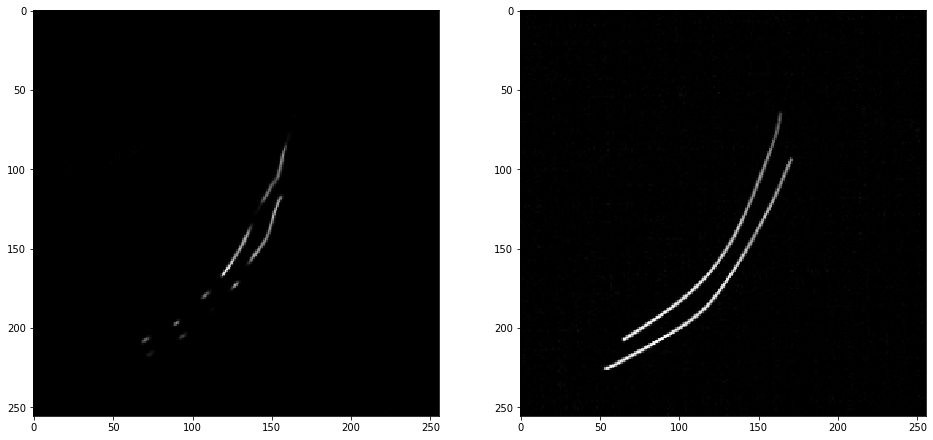

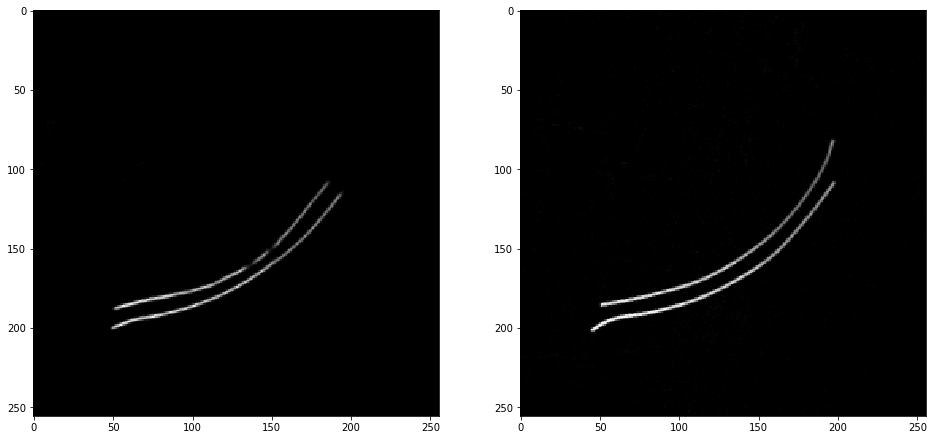

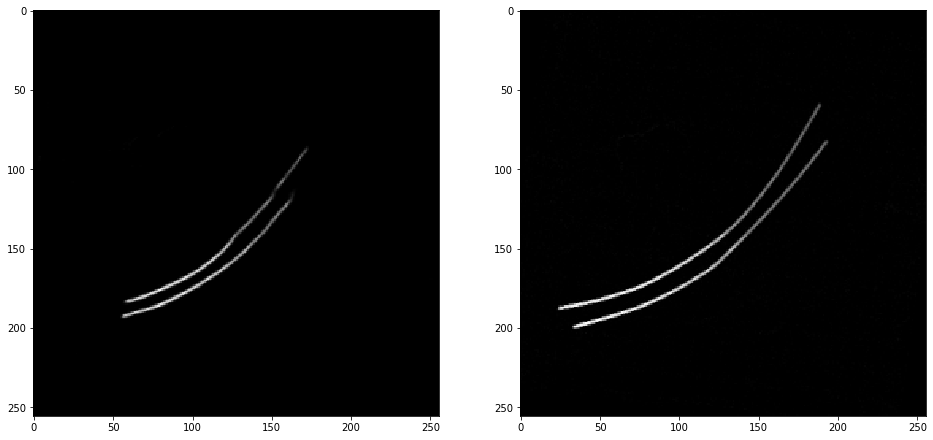

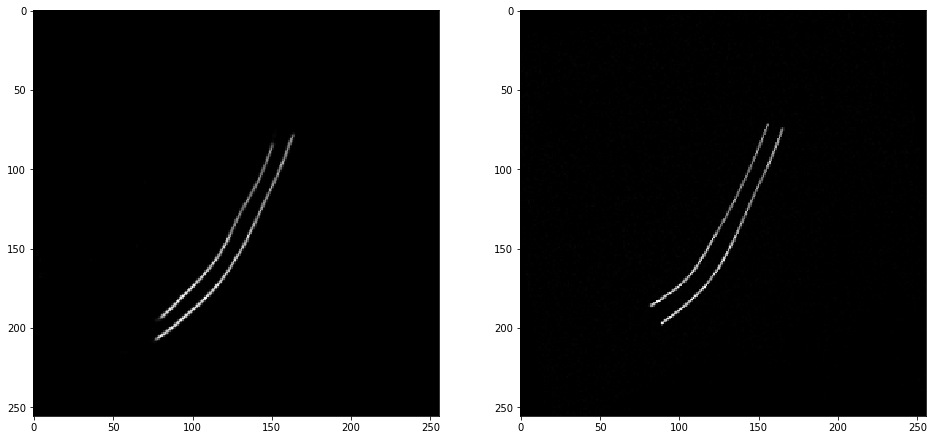

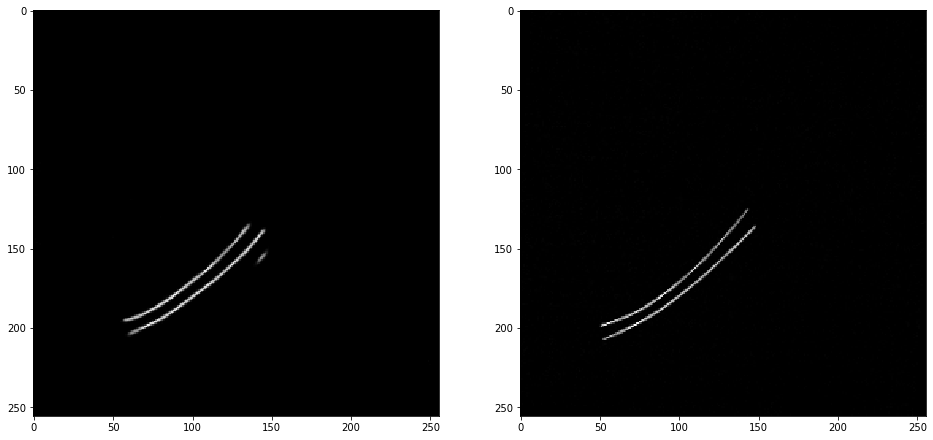

In [15]:
for x in range(5):
    plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(X_train[1000+x,:,:,0],cmap='Greys_r')

    plt.subplot(122)
    plt.imshow(y_train[1000+x,:,:,0],cmap='Greys_r')

In [16]:

model = unet()
model.summary()
history_list = []

sav_path = 'sav/Inpaint0to1_unet_256/'
if not os.path.isdir(sav_path):
    os.makedirs(sav_path)
    
checkpointer = ModelCheckpoint(sav_path+'{epoch:04d}.hdf5' ,
                                verbose=1, save_weights_only=True, period=10)
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    batch_size=16,
                    epochs=300,
                    shuffle=True,
                    callbacks=[checkpointer])

history_list.append(history)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
_____________________________________

/root/miniconda3/envs/tf13/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 6699 samples, validate on 46 samples
Epoch 1/300
6699/6699 [==============================] - 99s 15ms/step - loss: 0.0010 - acc: 0.5844 - val_loss: 0.0016 - val_acc: 0.8296
Epoch 2/300
6699/6699 [==============================] - 94s 14ms/step - loss: 9.5305e-04 - acc: 0.5844 - val_loss: 0.0015 - val_acc: 0.8296
Epoch 3/300
6699/6699 [==============================] - 94s 14ms/step - loss: 9.2355e-04 - acc: 0.5844 - val_loss: 0.0015 - val_acc: 0.8296
Epoch 4/300
6699/6699 [==============================] - 93s 14ms/step - loss: 9.0989e-04 - acc: 0.5844 - val_loss: 0.0015 - val_acc: 0.8296
Epoch 5/300
6699/6699 [==============================] - 93s 14ms/step - loss: 8.8786e-04 - acc: 0.5844 - val_loss: 0.0015 - val_acc: 0.8296
Epoch 6/300
6699/6699 [==============================] - 93s 14ms/step - loss: 8.6845e-04 - acc: 0.5844 - val_loss: 0.0015 - val_acc: 0.8296
Epoch 7/300
6699/6699 [==============================] - 93s 14ms/step - loss: 8.4013e-04 - acc: 0.5844 - val_lo

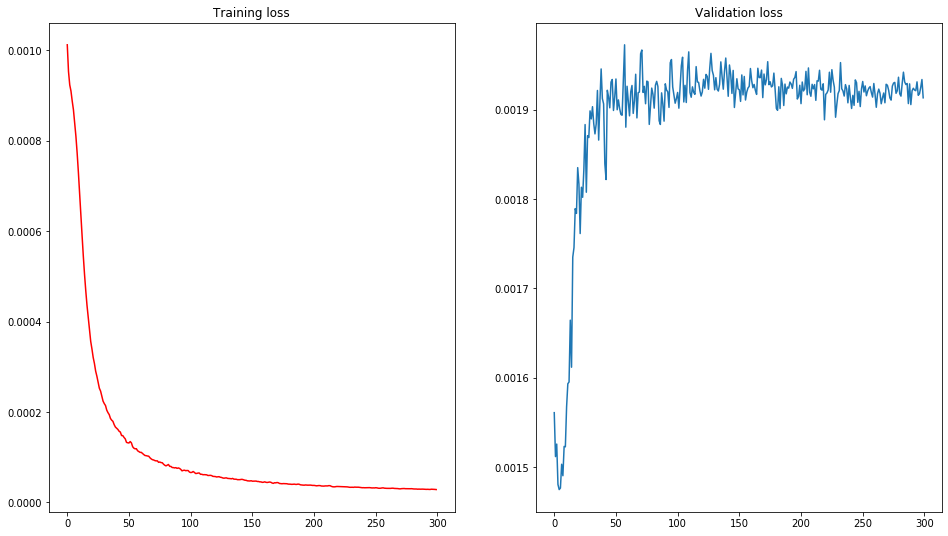

In [17]:

loss = history_list[0].history['loss']
val_loss = history_list[0].history['val_loss']


epochs = range(0,300)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))

ax1.set_title('Training loss')
ax1.plot(epochs, loss,'r-',label='Training loss')
ax2.set_title('Validation loss')
ax2.plot(epochs,val_loss,'-',label='Validation loss')


In [18]:
y_fit = model.predict(X_test)

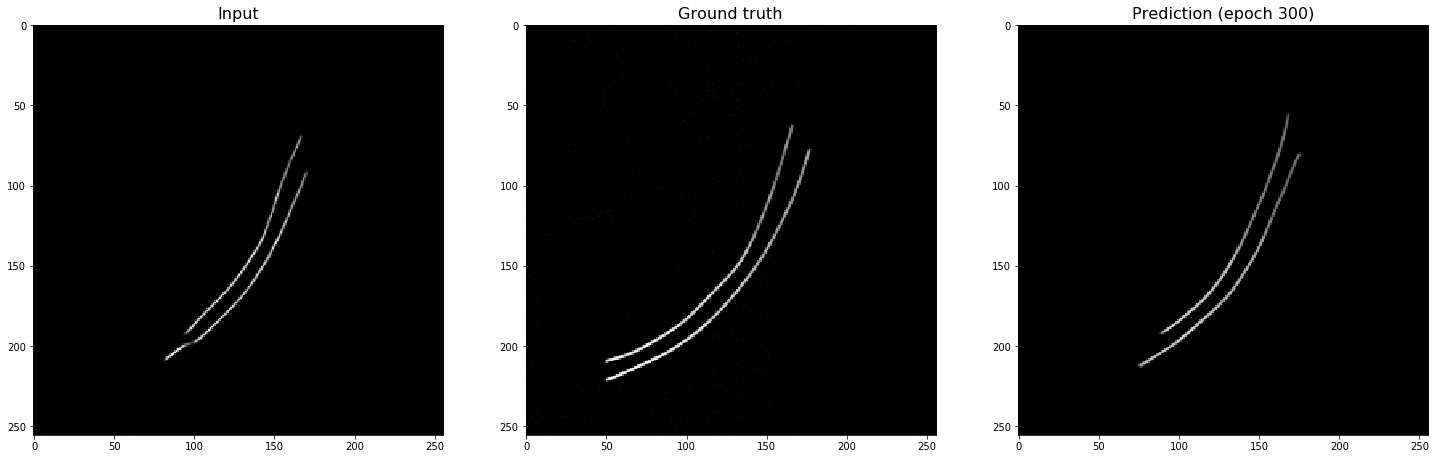

gt mean : 0.0060558245
pred (300) mean: 0.004641716
gt max : 0.7254902
pred max : 0.55108166


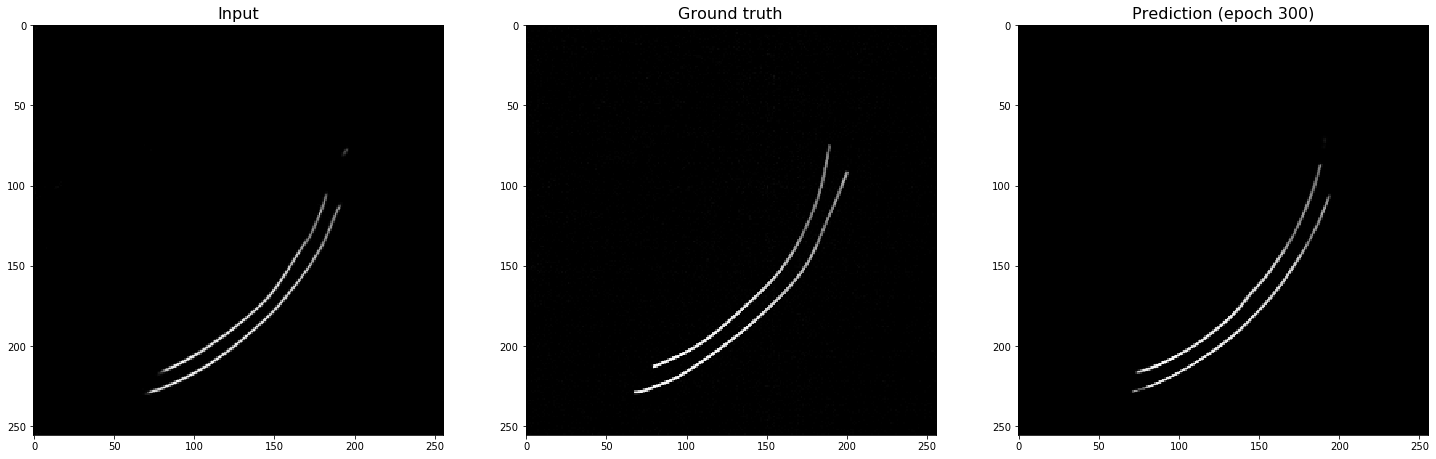

gt mean : 0.00750134
pred (300) mean: 0.0066572647
gt max : 0.8156863
pred max : 0.8069744


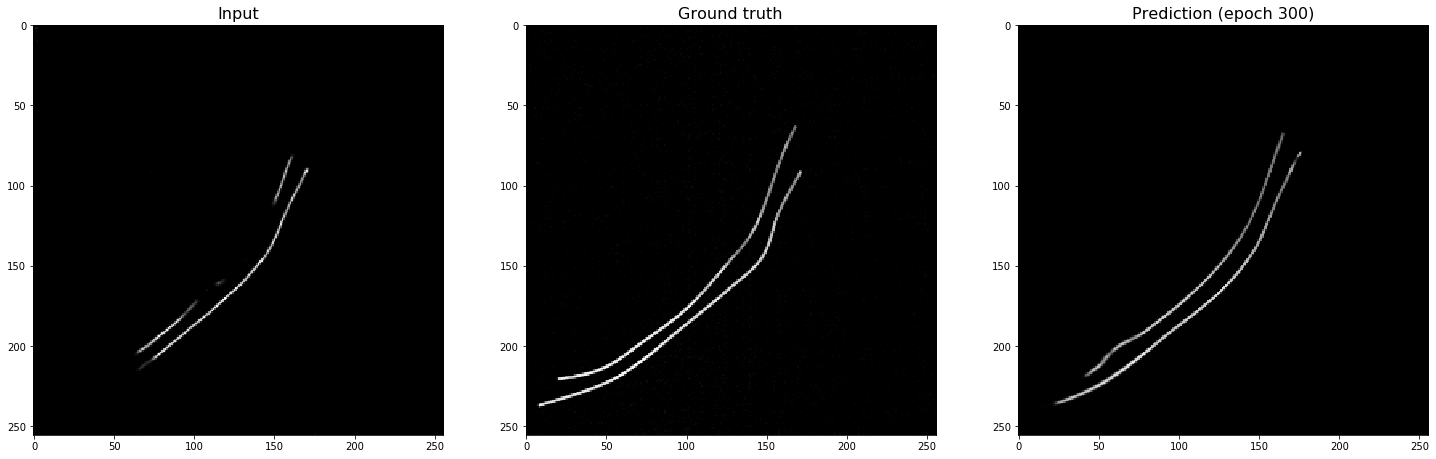

gt mean : 0.0059734867
pred (300) mean: 0.0050194343
gt max : 0.5686275
pred max : 0.4951316


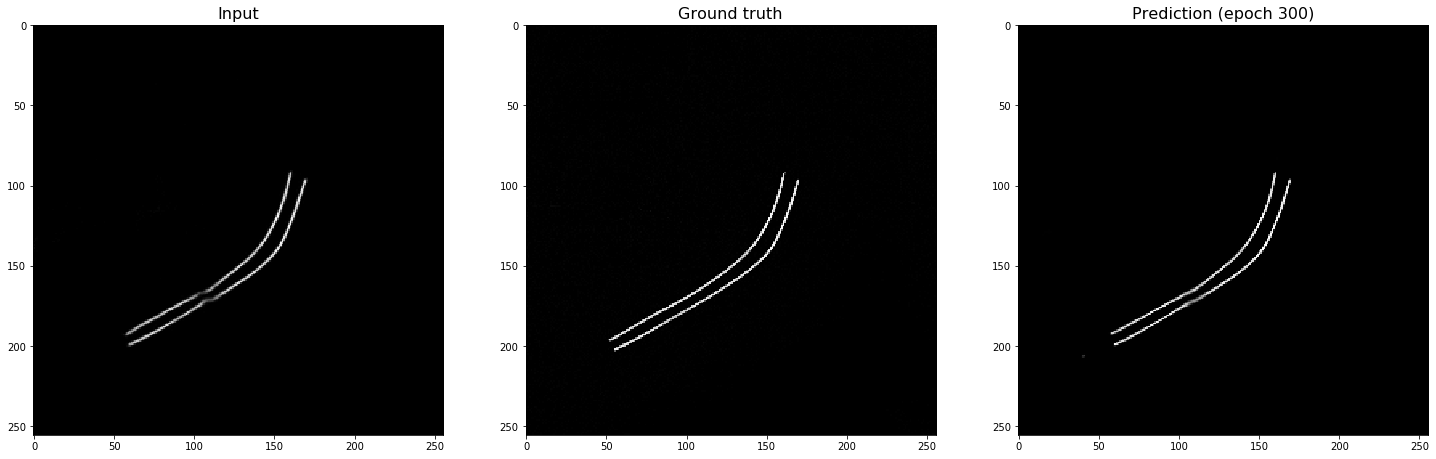

gt mean : 0.0069484343
pred (300) mean: 0.0065469667
gt max : 0.9098039
pred max : 1.0214007


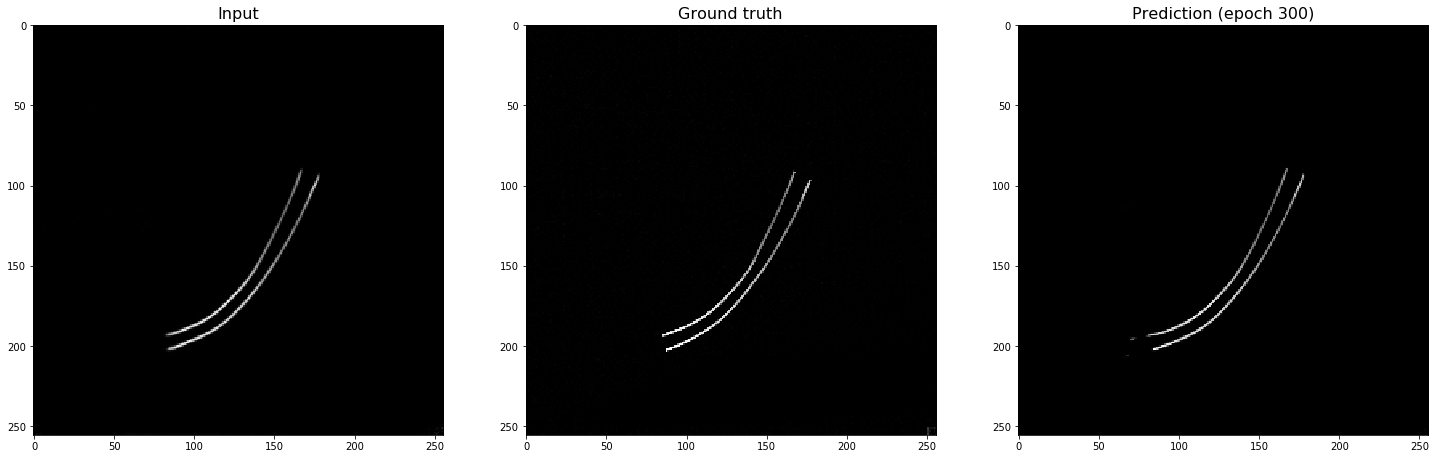

gt mean : 0.0049378644
pred (300) mean: 0.004677436
gt max : 0.83137256
pred max : 0.8651813


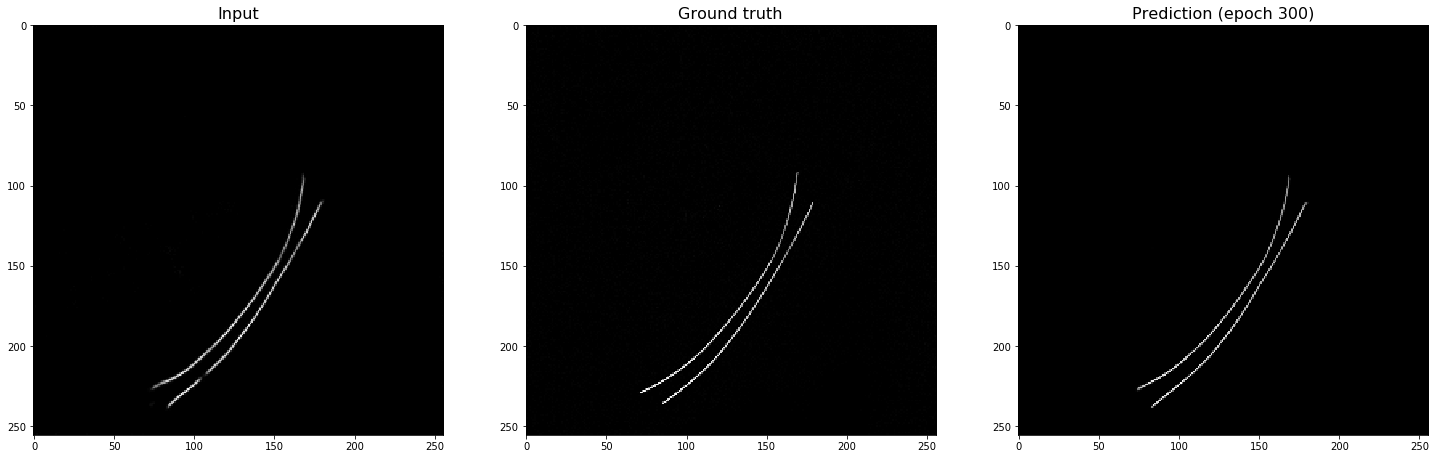

gt mean : 0.005537265
pred (300) mean: 0.0050498904
gt max : 0.9411765
pred max : 0.9458377


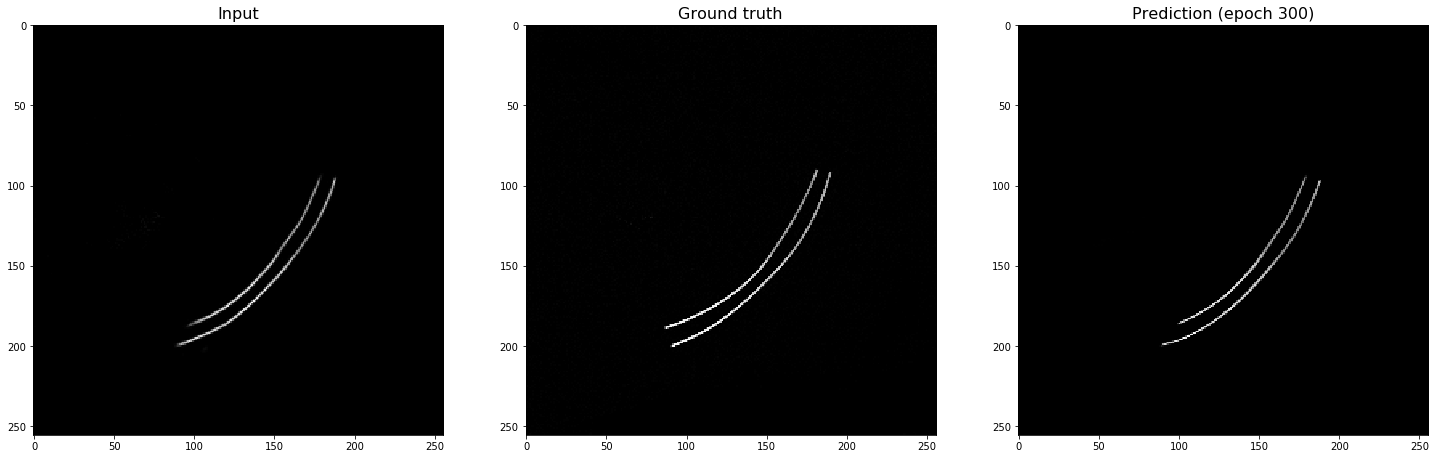

gt mean : 0.0060122022
pred (300) mean: 0.004911897
gt max : 0.93333334
pred max : 0.99351317


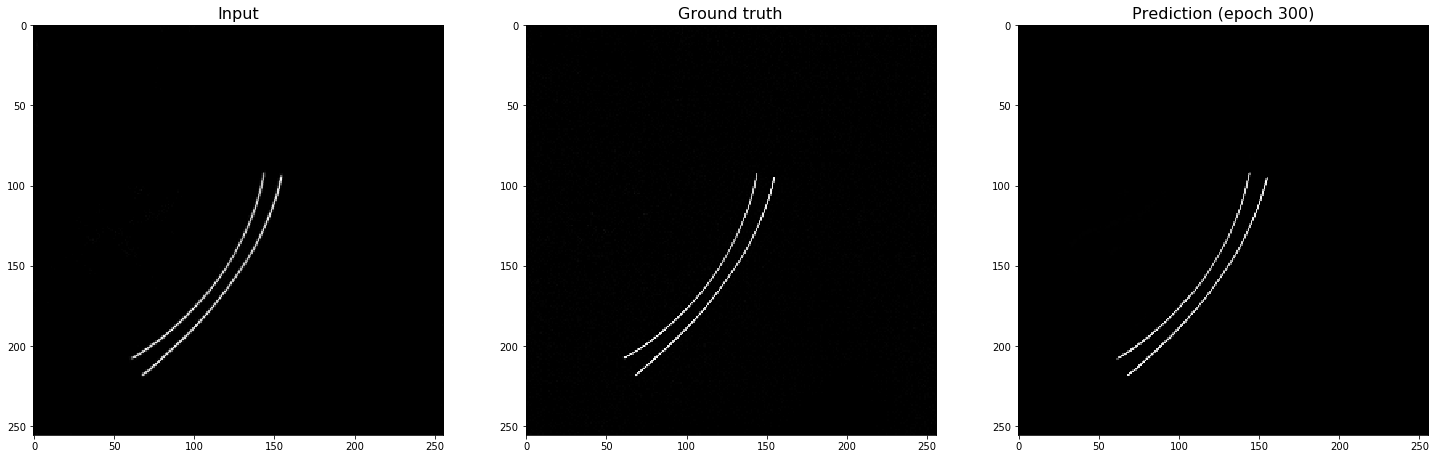

gt mean : 0.0050318697
pred (300) mean: 0.004831553
gt max : 0.8156863
pred max : 0.87923765


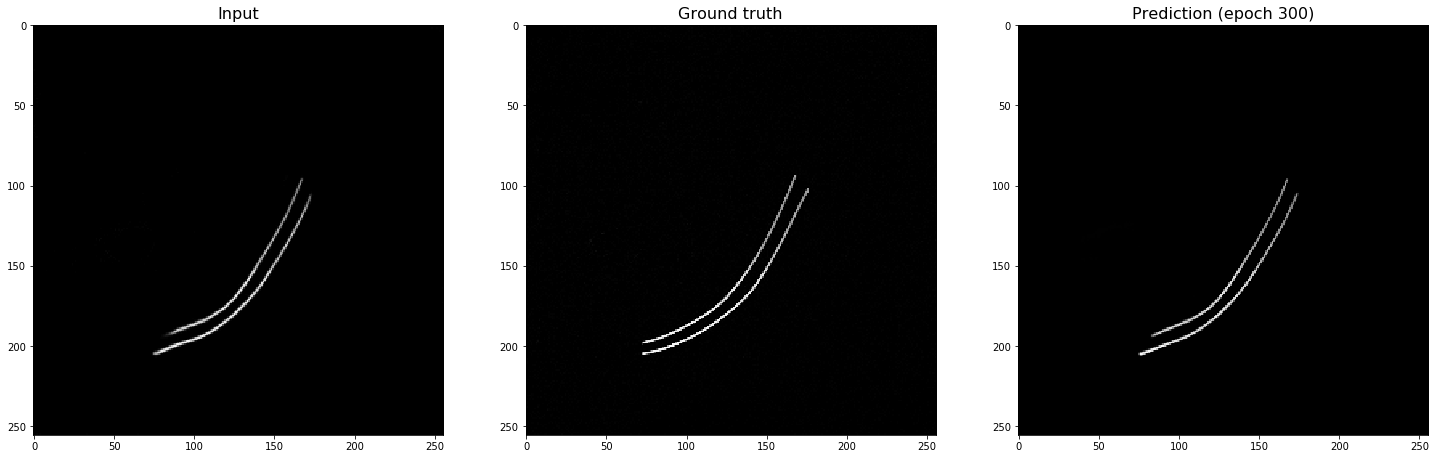

gt mean : 0.0062689087
pred (300) mean: 0.00519585
gt max : 0.85490197
pred max : 0.8561126


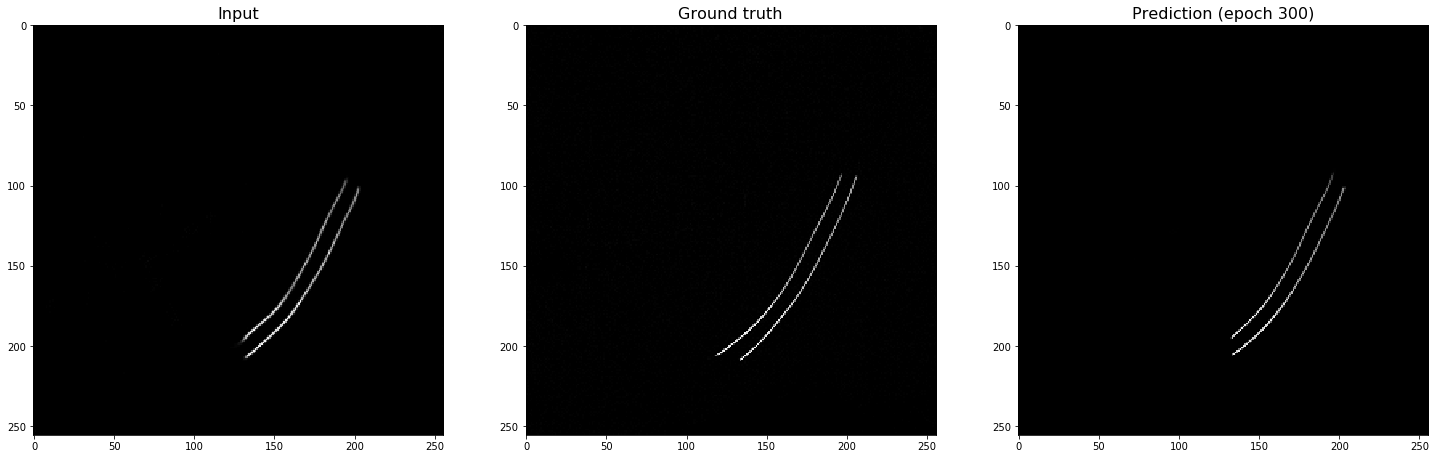

gt mean : 0.0046658386
pred (300) mean: 0.003875625
gt max : 0.93333334
pred max : 0.9047836


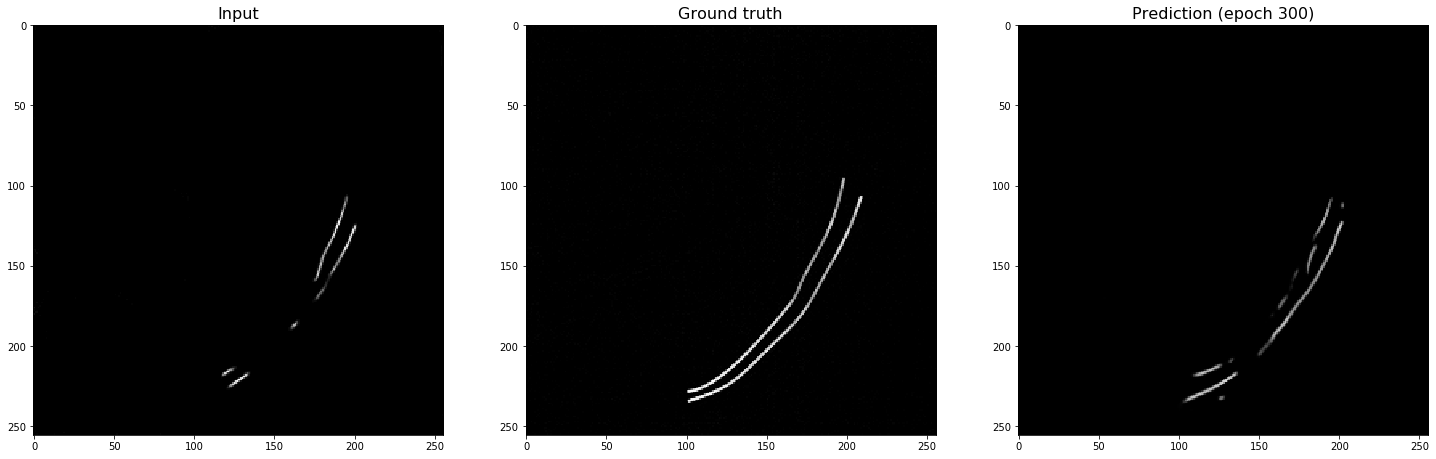

gt mean : 0.0058362177
pred (300) mean: 0.0036052486
gt max : 0.73333335
pred max : 0.53973156


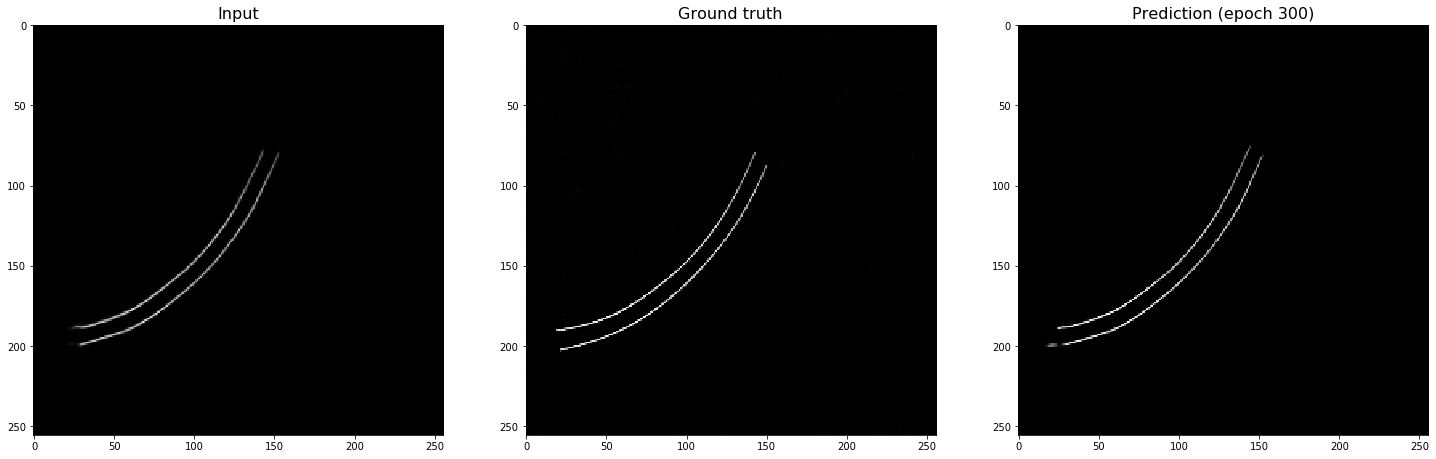

gt mean : 0.005247348
pred (300) mean: 0.004863131
gt max : 0.84705883
pred max : 0.8291548


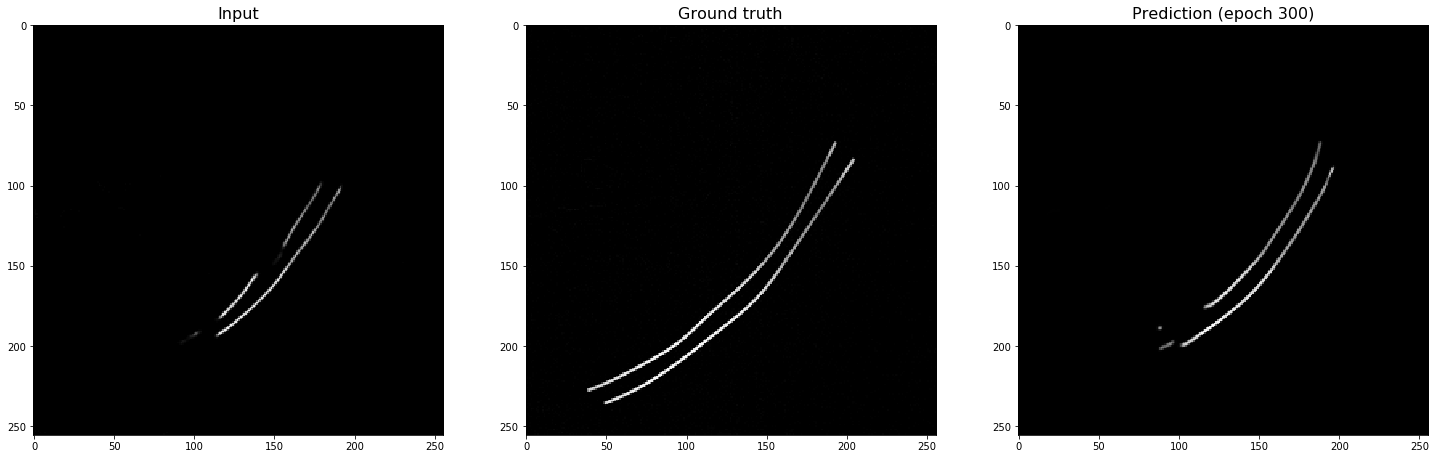

gt mean : 0.007860132
pred (300) mean: 0.005206787
gt max : 0.78039217
pred max : 0.7812788


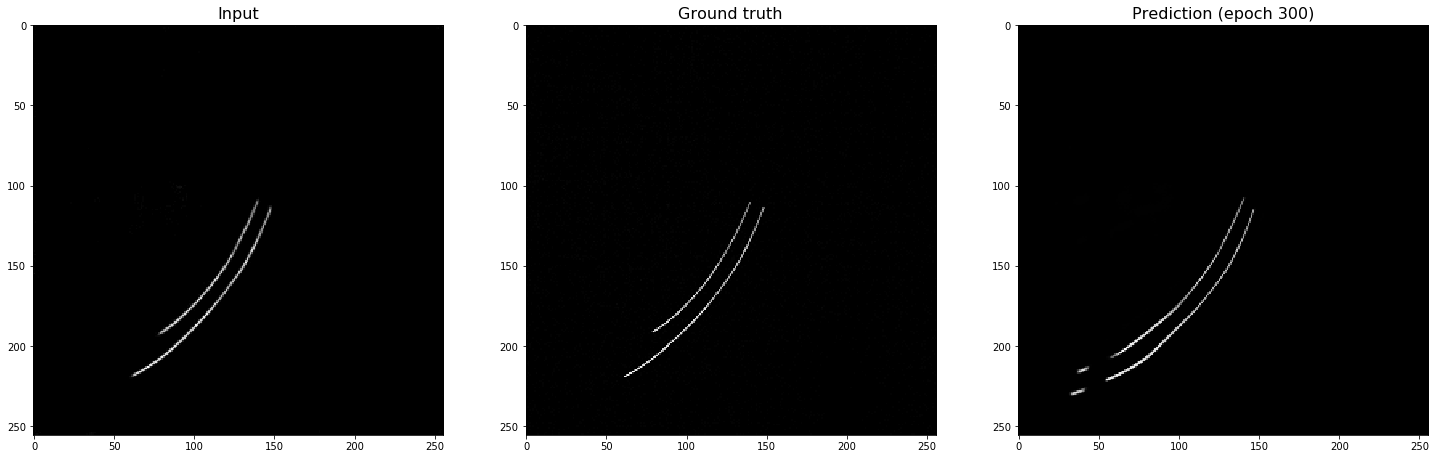

gt mean : 0.0024064607
pred (300) mean: 0.0038025426
gt max : 0.6196078
pred max : 0.6736259


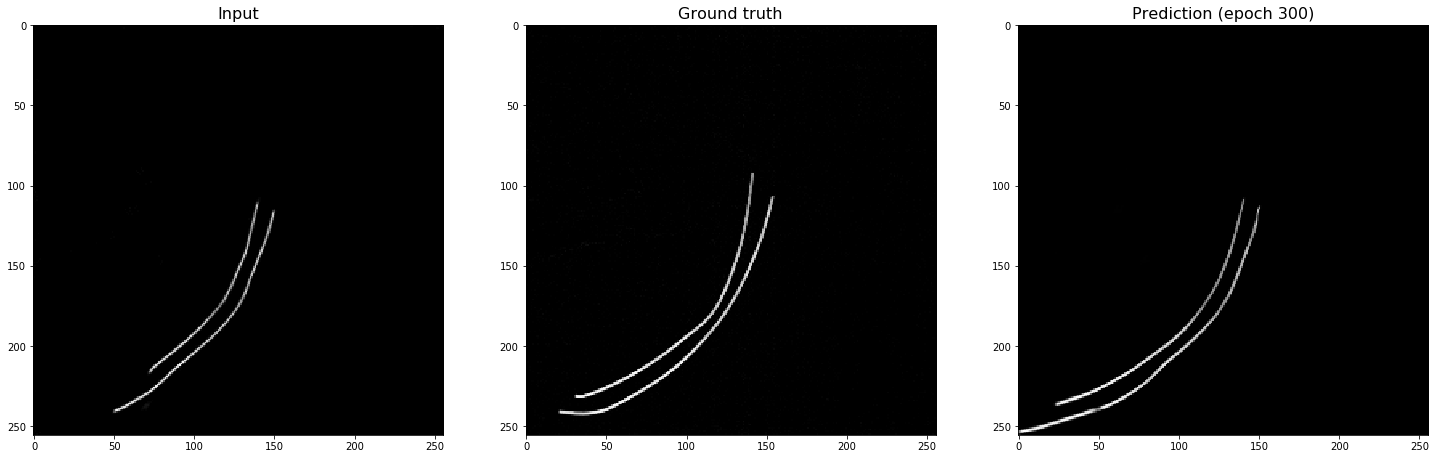

gt mean : 0.006685205
pred (300) mean: 0.0066420687
gt max : 0.69411767
pred max : 0.72411585


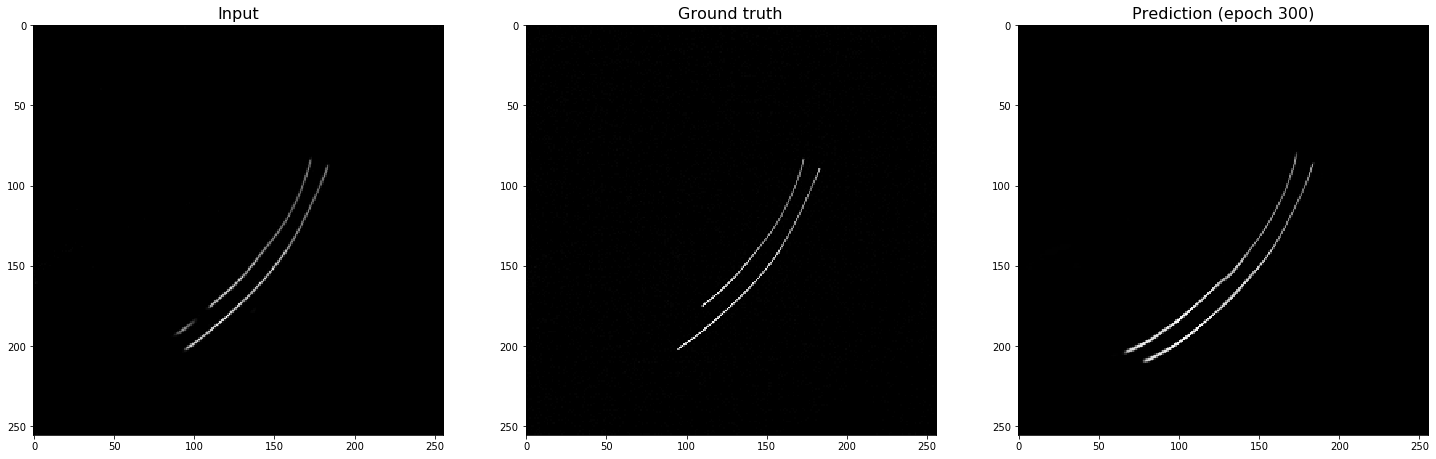

gt mean : 0.002681478
pred (300) mean: 0.0045956755
gt max : 0.6588235
pred max : 0.6595336


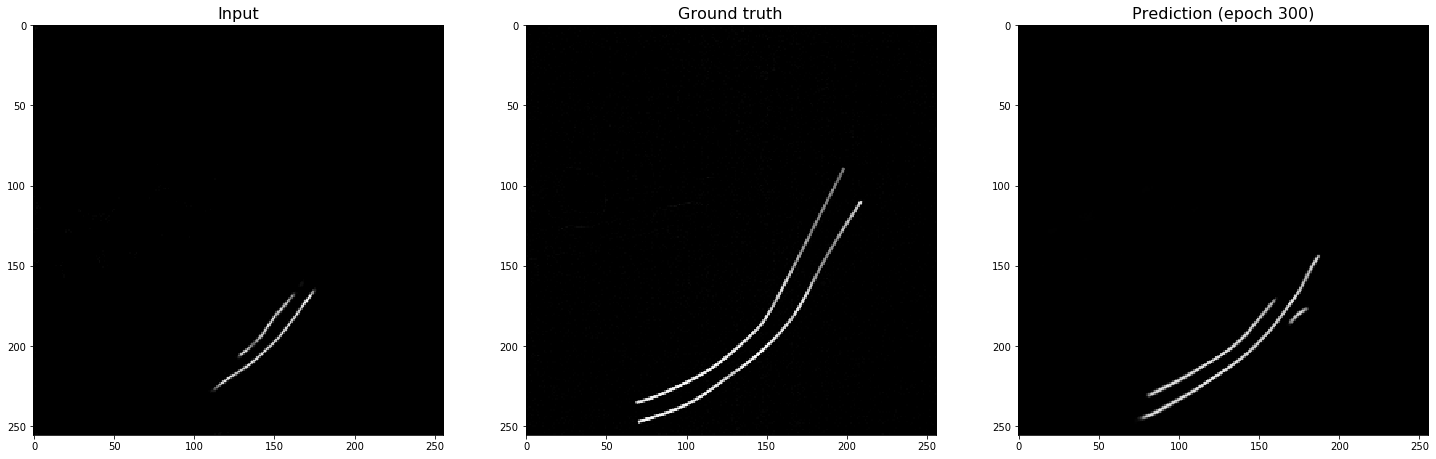

gt mean : 0.0069384407
pred (300) mean: 0.0055520902
gt max : 0.7411765
pred max : 0.6367959


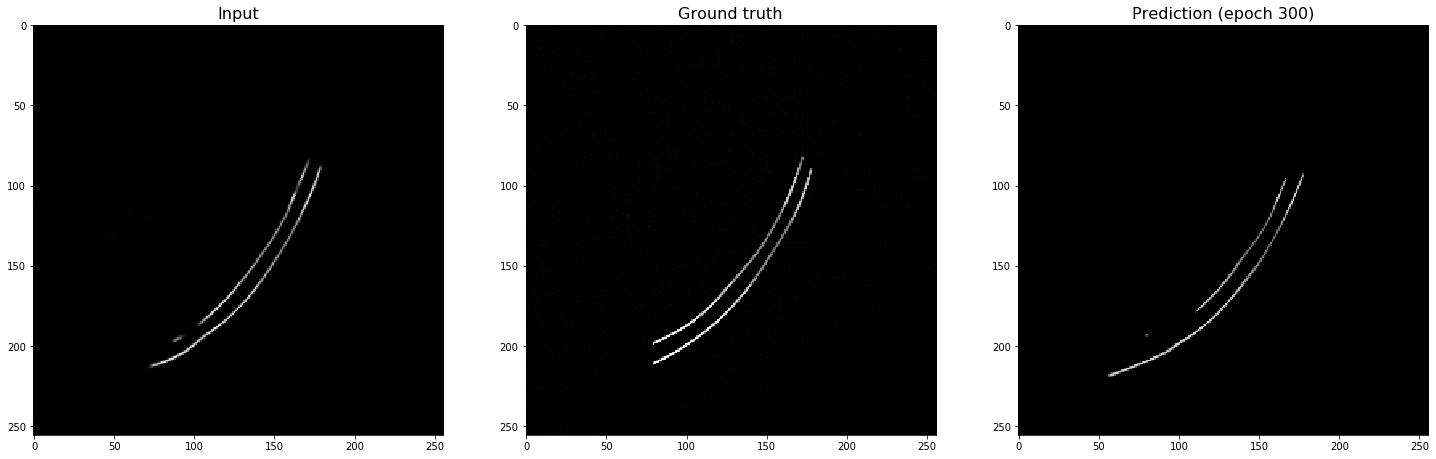

gt mean : 0.006170116
pred (300) mean: 0.004564918
gt max : 0.9490196
pred max : 0.805721


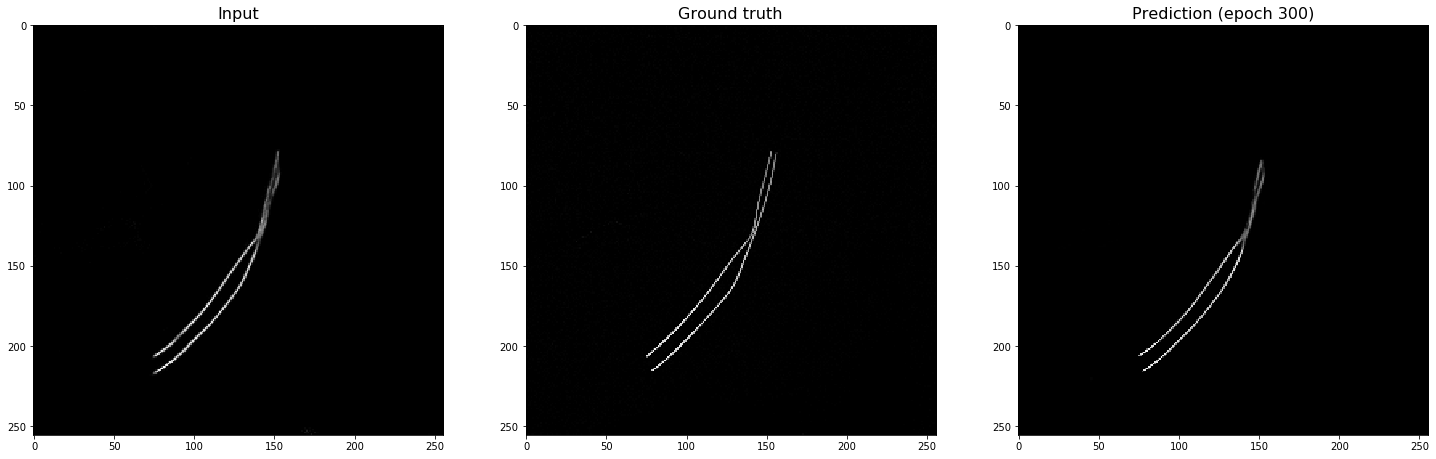

gt mean : 0.0049850163
pred (300) mean: 0.0045133005
gt max : 0.93333334
pred max : 0.9022831


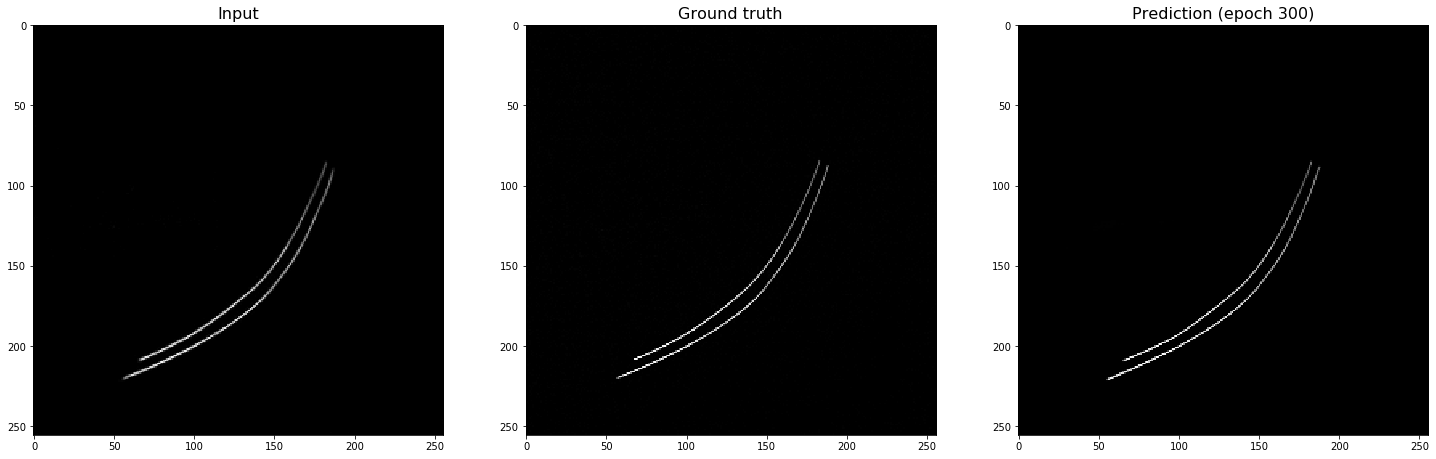

gt mean : 0.0043264353
pred (300) mean: 0.0050271293
gt max : 0.8627451
pred max : 0.9365424


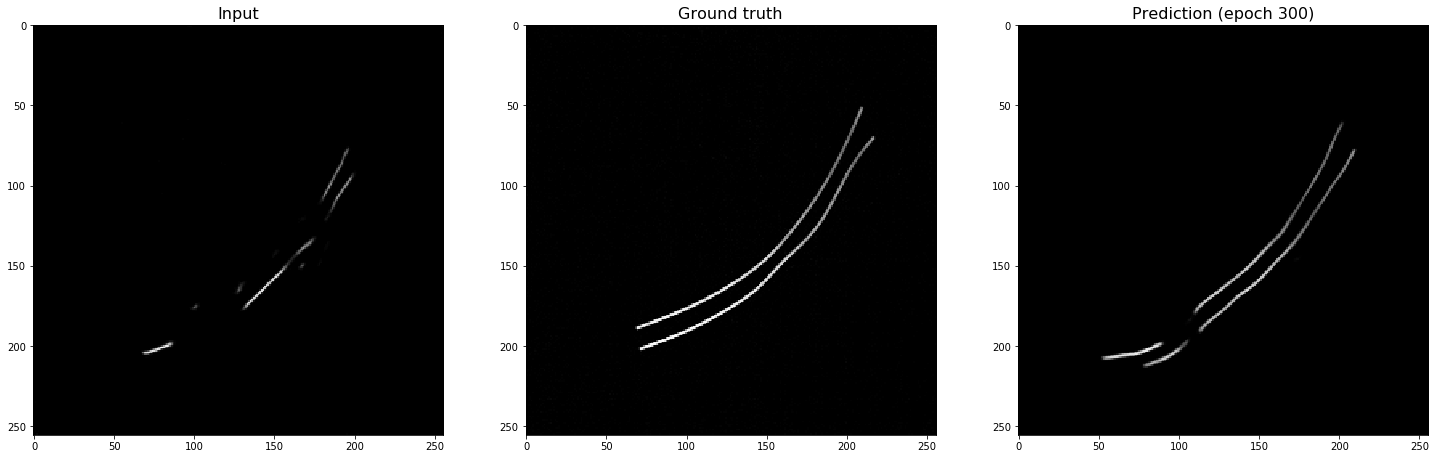

gt mean : 0.007264141
pred (300) mean: 0.0057781953
gt max : 0.8235294
pred max : 0.7500518


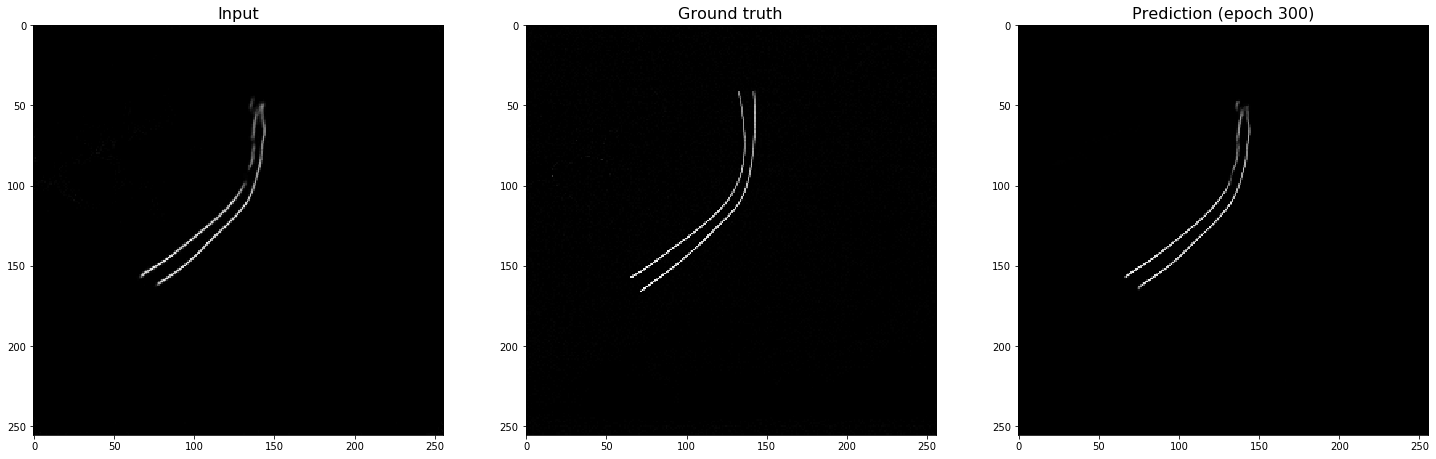

gt mean : 0.0050930846
pred (300) mean: 0.0043748287
gt max : 0.92156863
pred max : 0.89309067


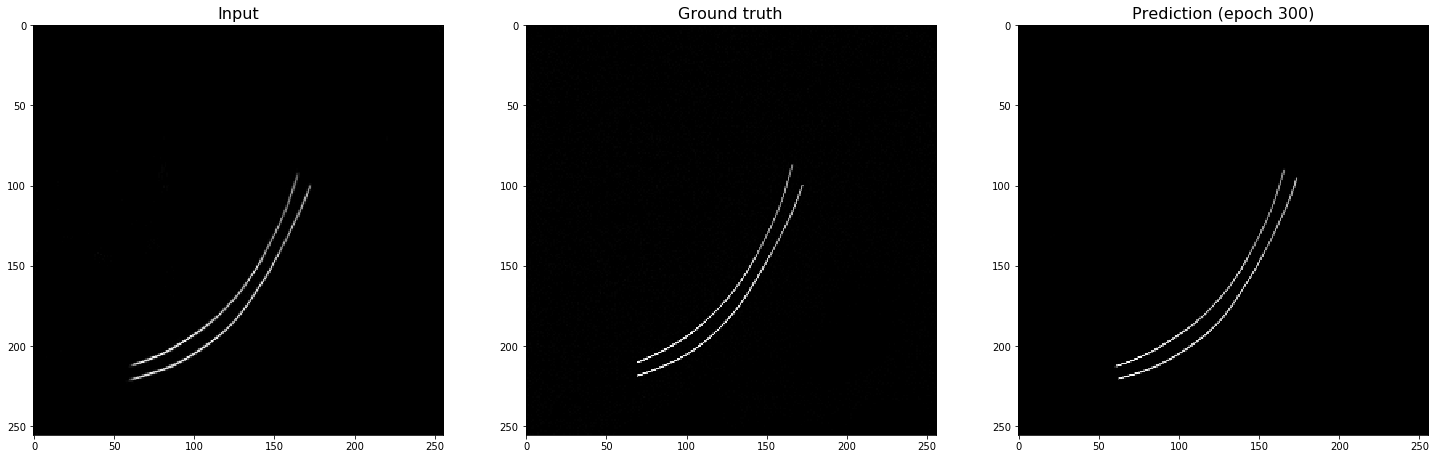

gt mean : 0.005252016
pred (300) mean: 0.005163571
gt max : 0.91764706
pred max : 0.96347356


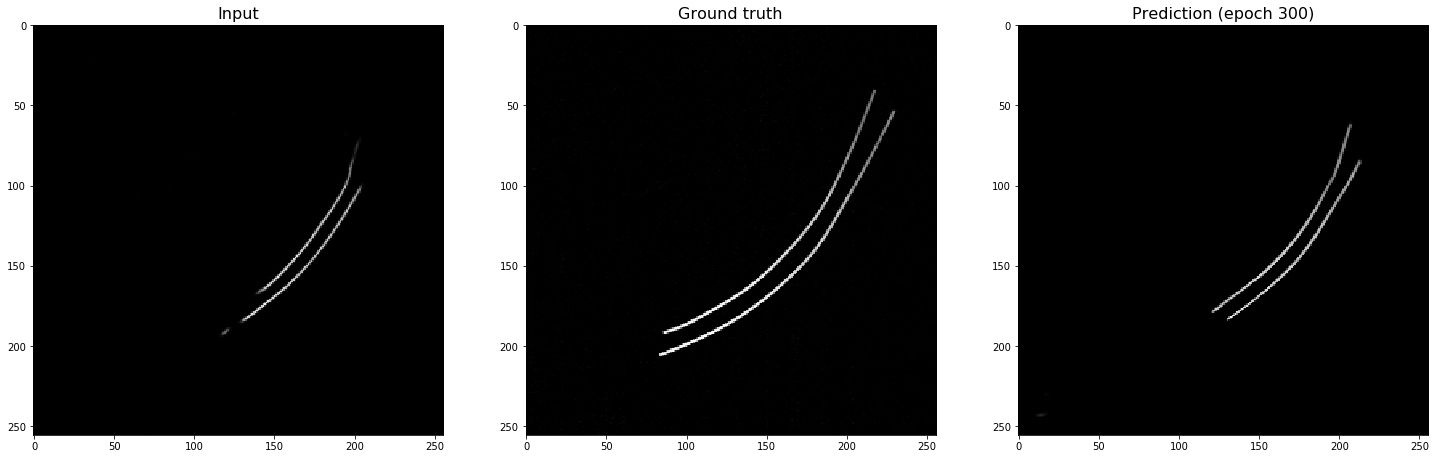

gt mean : 0.0075021777
pred (300) mean: 0.004757947
gt max : 0.78039217
pred max : 0.6976073


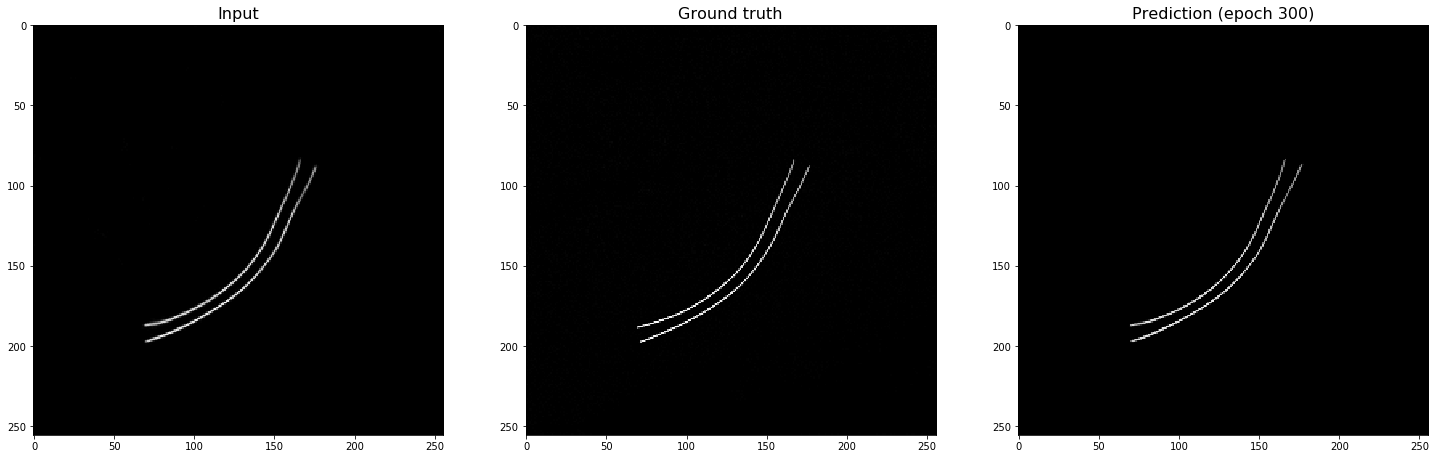

gt mean : 0.0052745743
pred (300) mean: 0.0051886807
gt max : 0.9529412
pred max : 0.84271216


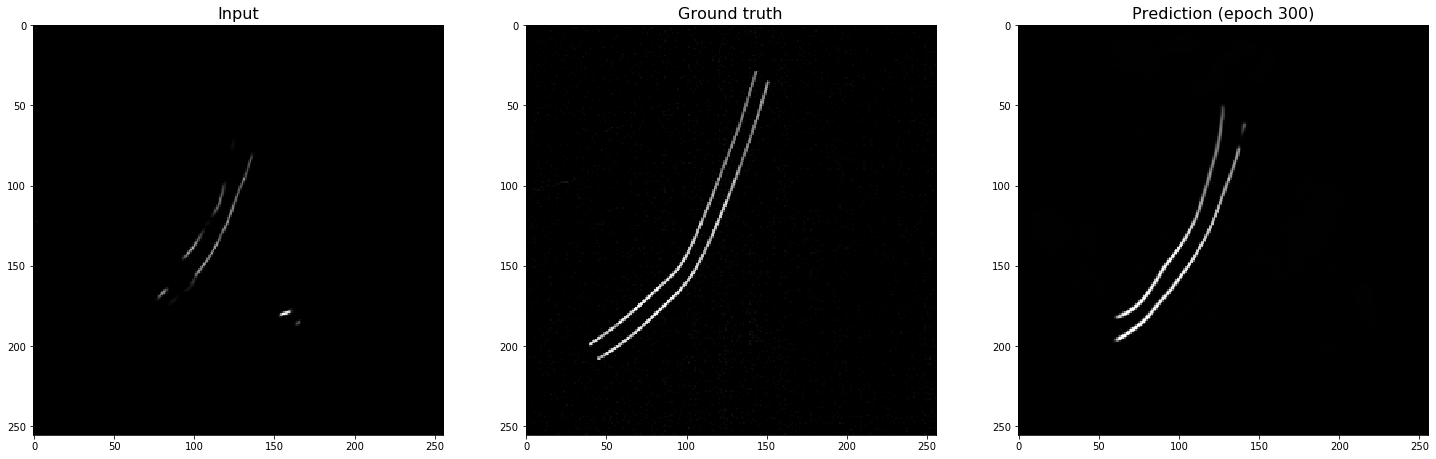

gt mean : 0.00357307
pred (300) mean: 0.003749833
gt max : 0.39215684
pred max : 0.49754483


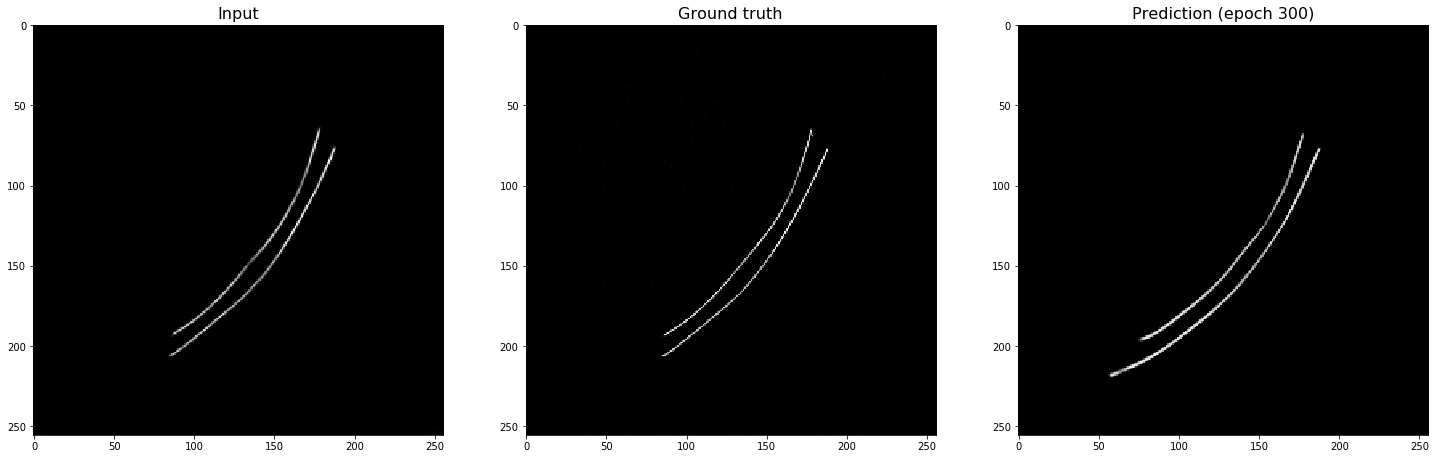

gt mean : 0.0036354214
pred (300) mean: 0.0059788716
gt max : 0.73725486
pred max : 0.6491288


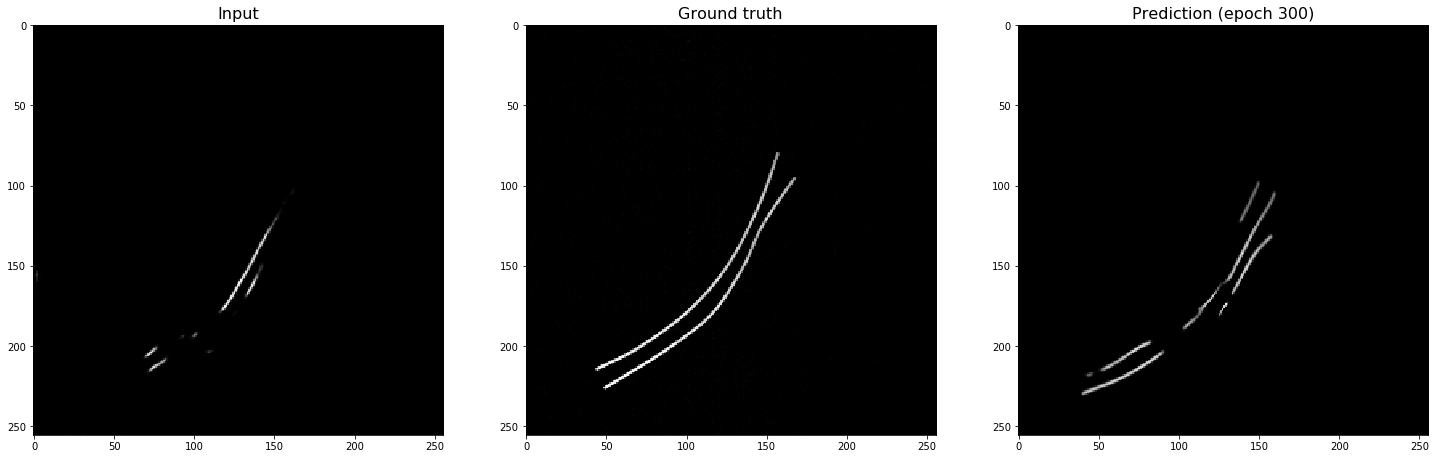

gt mean : 0.007574583
pred (300) mean: 0.0051715323
gt max : 0.87058824
pred max : 0.7550048


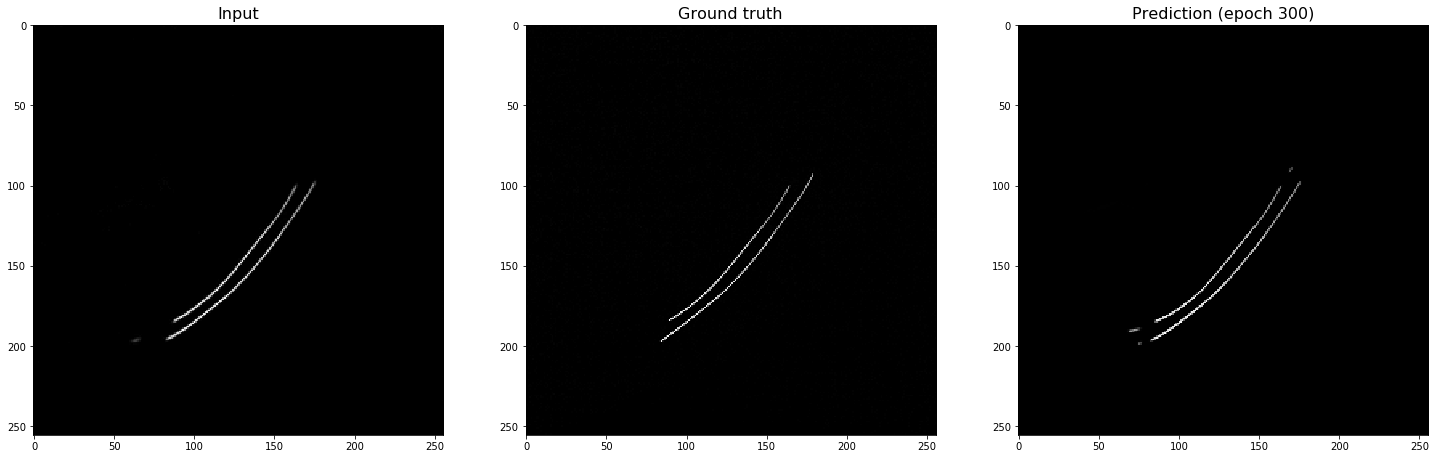

gt mean : 0.0036561256
pred (300) mean: 0.004429621
gt max : 0.91764706
pred max : 0.909045


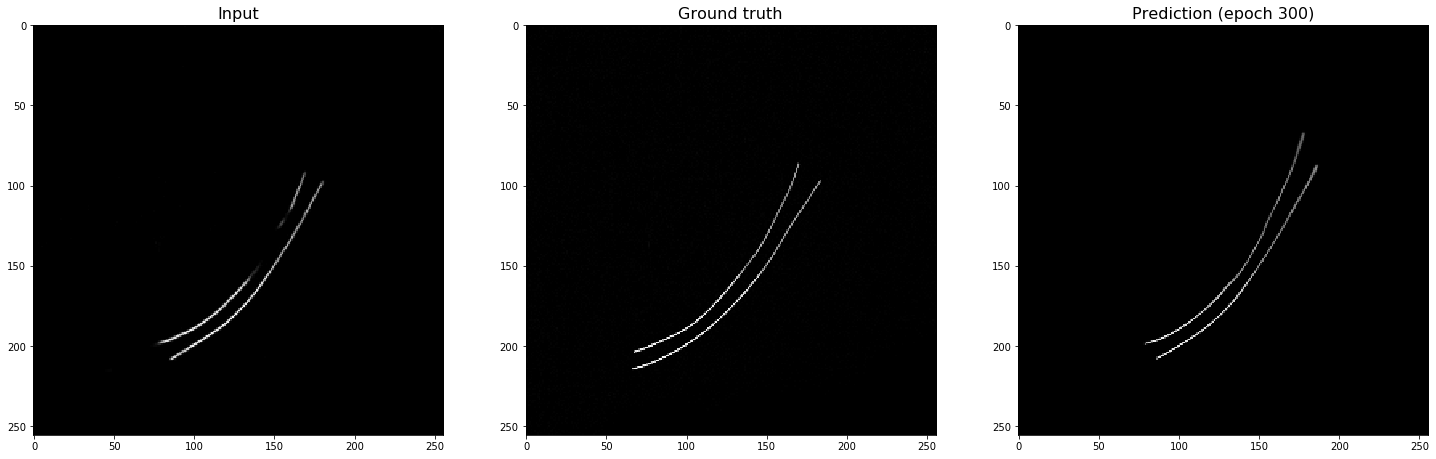

gt mean : 0.005280798
pred (300) mean: 0.004462718
gt max : 0.93333334
pred max : 0.8837682


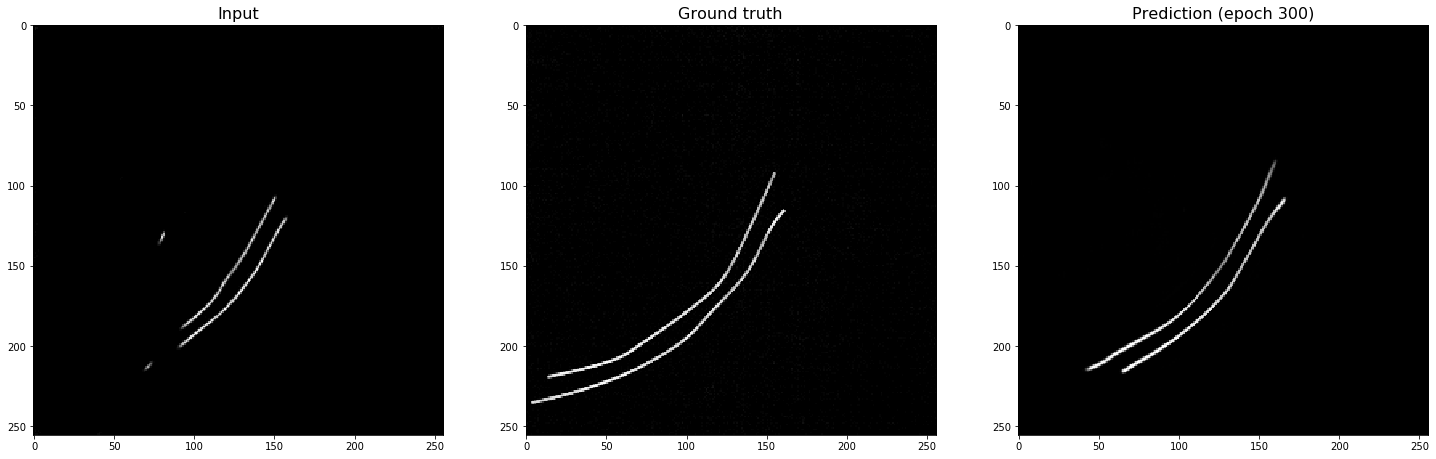

gt mean : 0.0054214178
pred (300) mean: 0.0046254364
gt max : 0.47843134
pred max : 0.56756365


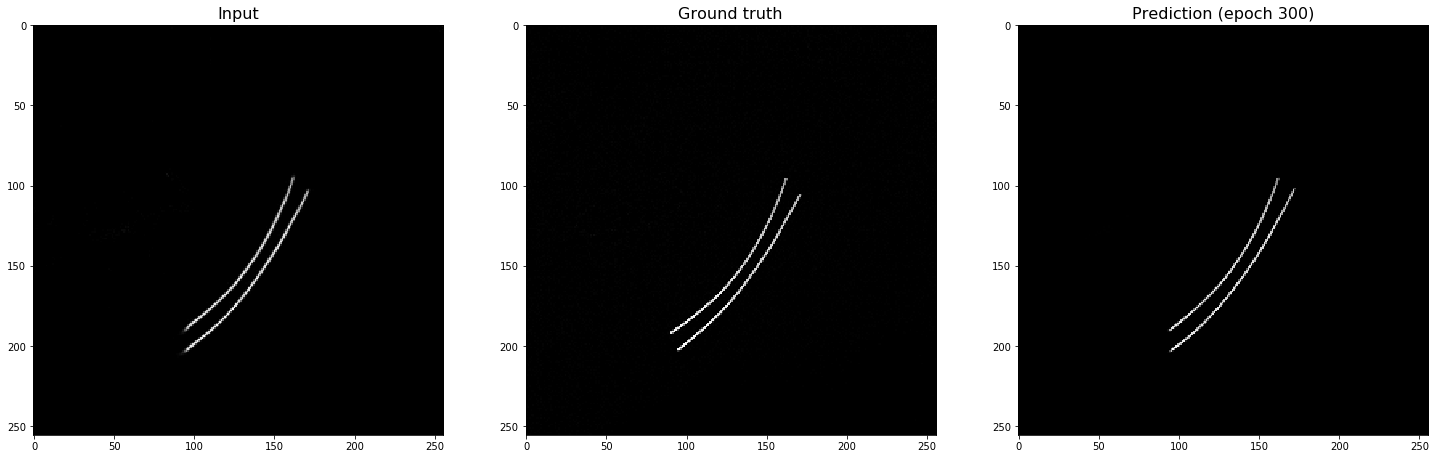

gt mean : 0.0055763396
pred (300) mean: 0.005169509
gt max : 0.9372549
pred max : 0.92286515


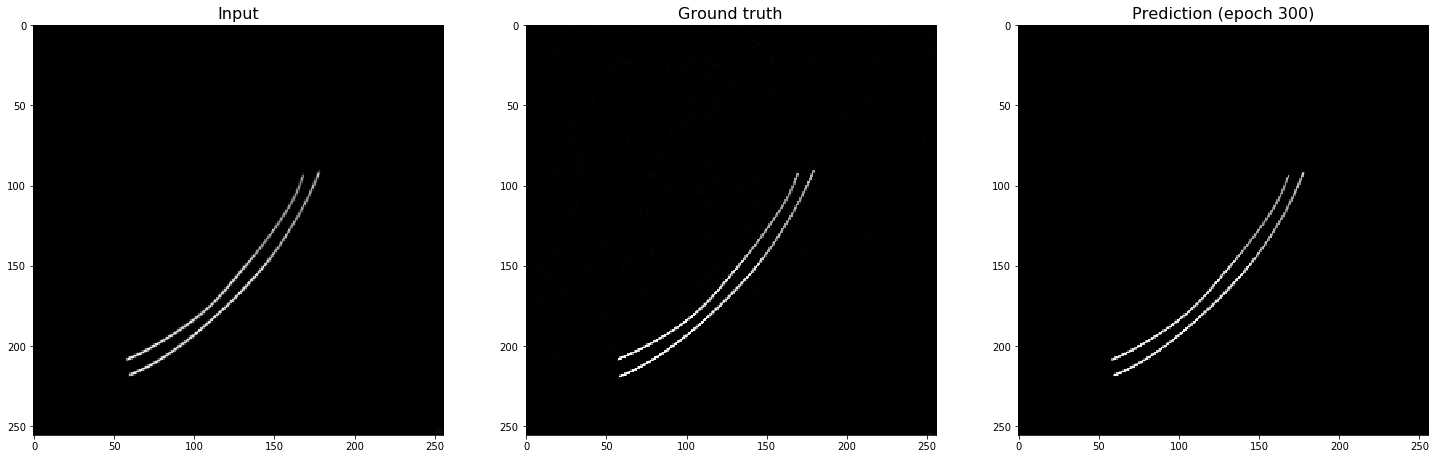

gt mean : 0.0072732363
pred (300) mean: 0.0066285674
gt max : 0.9254902
pred max : 0.98233825


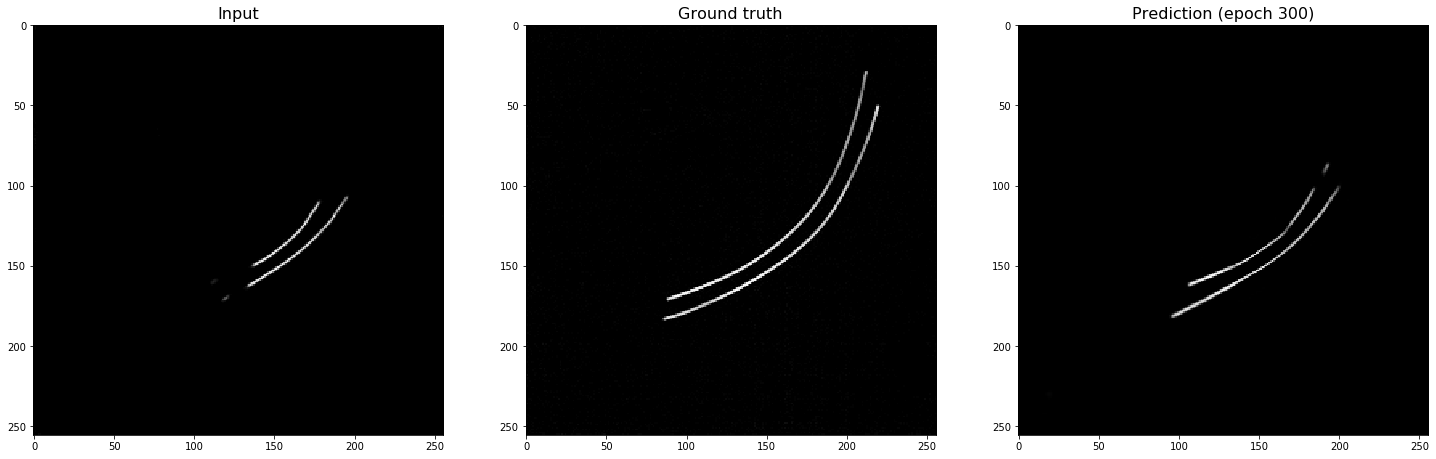

gt mean : 0.0054150145
pred (300) mean: 0.0035709853
gt max : 0.5764706
pred max : 0.5595379


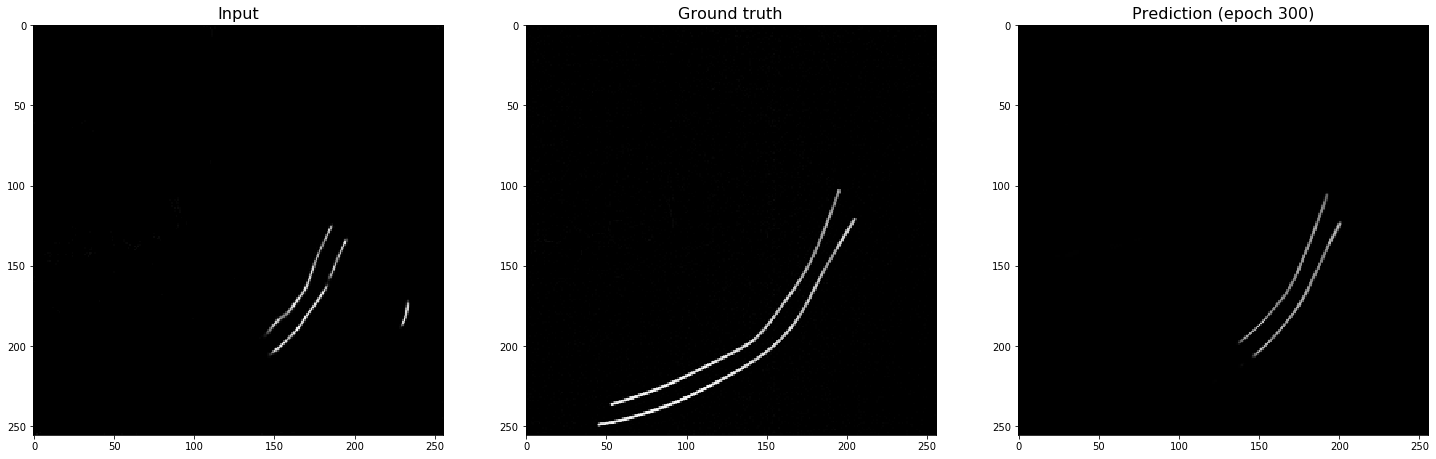

gt mean : 0.0077445833
pred (300) mean: 0.0035392973
gt max : 0.78431374
pred max : 0.54561085


In [19]:
for x in range(len(X_test)):
    fig, (ax3,ax1,ax2) = plt.subplots(1, 3, figsize=(25, 14))
    #plt.rc('figure',titlesize=16)
    
    ax1.set_title('Ground truth',fontsize=16)
    gt = y_test[x,:,:,0]
    ax1.imshow(y_test[x,:,:,0],cmap='Greys_r')

    ax2.set_title('Prediction (epoch 300)',fontsize=16)
    pred = y_fit[x,:,:,0]
    ax2.imshow(pred,cmap='Greys_r',vmin=gt.min(),vmax=gt.max())
    
    ax3.set_title('Input',fontsize=16)
    t = X_test[x,:,:,0]
    ax3.imshow(t,cmap='Greys_r')
    
    plt.show()
    
    print('gt mean :',np.mean(gt))
    print('pred (300) mean:',np.mean(pred))
    print('gt max :',np.max(gt))
    print('pred max :',np.max(pred))
        
        
    
    